In [1]:
import pandas as pd
import numpy as np
import os
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
from util import get_data
from marketsimcode import *
from tabulate import tabulate

In [2]:
def getprices(symbol, start_date, end_date):
    prices = get_data([symbol], pd.date_range(start_date, end_date))
    if 'SPY' not in symbol:
        prices.drop('SPY', axis=1, inplace=True)

    prices = prices.fillna(method='ffill')
    prices = prices.fillna(method='bfill')
    prices_normed = prices / prices.iloc[0]
    return prices_normed

In [3]:
def Portfolio_Statistics(portvals):
    daily_returns = portvals.copy()
    daily_returns[1:] = (portvals[1:] / portvals[:-1].values) - 1
    daily_returns = daily_returns[1:]

    cum_ret = (portvals.iloc[-1] / portvals.iloc[0]) - 1
    avg_daily_ret = daily_returns.mean()
    std_daily_ret = daily_returns.std()
    sharpe_ratio = np.sqrt(252.0) * (avg_daily_ret / std_daily_ret)

    return cum_ret,avg_daily_ret,std_daily_ret,sharpe_ratio

In [4]:
def benchmark(symbol, sd, ed, shares):
    prices =  getprices(symbol, sd, ed)

    df_trades = pd.DataFrame(index=prices.index)
    df_trades[symbol] = 0

    start = df_trades.index.min()
    end = df_trades.index.max()
    df_trades.loc[start, symbol] = shares
    df_trades.loc[end, symbol] = -1 * shares
    return df_trades


In [5]:
# Indicator 1 - Simple Moving Average
def getsma(prices, moving_window):
    sma = prices.rolling(window=moving_window).mean()
    sma_by_price = prices/sma
    return sma, sma_by_price

def getMomentum(prices,moving_window):
    momentum = prices/prices.shift(moving_window) - 1
    return momentum

def getBBP(prices, moving_window):
    rolling_mean = prices.rolling(window=moving_window).mean()
    rolling_std = prices.rolling(window=moving_window).std()
    upperband = rolling_mean + (2 * rolling_std)
    lowerband = rolling_mean - (2 * rolling_std)
    BBP = (prices - lowerband) / (upperband - lowerband)
    return upperband, lowerband, BBP

***This is the final strategy **

In [6]:
def testPolicy(symbol = "AAPL", sd = dt.datetime(2010, 1, 1), ed = dt.datetime(2011,12,31), sv = 100000):
    
    signal = 0  #can be -1, 0, or 1, corresponding to a “short,” “out” or “long” position
    moving_window = 21
    prices = get_data([symbol], pd.date_range(sd, ed))
    
    if 'SPY' not in symbol:
            prices.drop('SPY', axis = 1, inplace = True)
    prices= prices.fillna(method ='ffill')
    prices = prices.fillna(method = 'bfill')
    prices = prices/prices.iloc[0,:]
    
    
    trades_df = pd.DataFrame(columns=['Order', 'Shares'], index = prices.index)
    
    sma, price_sma = getsma(prices, moving_window)

    upperband, lowerband, BBP = getBBP(prices, moving_window) 
    momentum = getMomentum(prices, moving_window)
   
    print('came here') 
    
    for index in range(prices.shape[0]):
        i = prices.index[index]
        if signal == 0:

            if price_sma.loc[i, symbol] < 0.6 or BBP.loc[i, symbol] < 0.2 or momentum.loc[i, symbol] < -0.1:
                trades_df.loc[i] = ['BUY', 1000]

                signal = 1

            elif price_sma.loc[i, symbol] > 1.0 or BBP.loc[i, symbol] > 0.8 or momentum.loc[i, symbol] > 0.1:
                trades_df.loc[i] = ['SELL', 1000]
                signal = -1

        elif signal == -1:

            if price_sma.loc[i, symbol] < 0.6 or BBP.loc[i, symbol] < 0.2 or momentum.loc[i, symbol] < -0.1:
                trades_df.loc[i] = ['BUY', 2000]
                signal = 1

        elif signal == 1:
            if price_sma.loc[i, symbol] > 1.3 or BBP.loc[i, symbol] > 0.8 or momentum.loc[i, symbol] > 0.2:
                trades_df.loc[i] = ['SELL', 2000]
                signal = -1
  

    trades_df['Shares'] = np.where(trades_df['Order'] =='BUY', trades_df['Shares'], -1 * trades_df['Shares'])
    trades_df = trades_df.loc[:,['Shares']]
    trades_df.columns = [symbol]
    trades_df.fillna(0, inplace =True)
        
    return trades_df

In [7]:
def test_code():
    start_date = dt.datetime(2008,1,1)
    end_date = dt.datetime(2009,12,31)
    symbol = "JPM"
    moving_window = 21
    
    
    #Manual Strategy
    df_trades_manual= testPolicy(symbol = "JPM", sd=start_date, ed=end_date, sv = 100000)
    port_vals_manual = compute_portvals(df_trades_manual, start_val = 100000, commission = 9.95, impact = 0.005)
    
    #Normalizing PortFolio Values
    port_vals_norm_manual = port_vals_manual/port_vals_manual.iloc[0]

    cum_ret_man,avg_daily_ret_man,std_daily_ret_man,sharpe_ratio_man = Portfolio_Statistics(port_vals_norm_manual)
    
    print(f"Date Range: {start_date} to {end_date} for {symbol}")
    print()
    print("Manual Strategy")
    print(f"Sharpe Ratio of Fund: {sharpe_ratio_man}")  
    print(f"Cumulative Return of Fund: {cum_ret_man}") 
    print(f"Standard Deviation of Fund: {std_daily_ret_man}")
    print(f"Average Daily Return of Fund: {avg_daily_ret_man}") 
    print(f"Final Portfolio Value: {port_vals_manual[-1]}")
    
    
    #Benchmark Strategy 

    df_trades_benchmark = benchmark(symbol = "JPM", sd=start_date, ed= end_date,shares = 1000)
    port_vals_benchmark = compute_portvals(df_trades_benchmark, start_val = 100000, commission = 9.95, impact = 0.005)
    
    #Normalizing PortFolio Values
    port_vals_norm_benchmark = port_vals_benchmark/port_vals_benchmark.iloc[0]

    cum_ret_bench,avg_daily_ret_bench,std_daily_ret_bench,sharpe_ratio_bench = Portfolio_Statistics(port_vals_norm_benchmark)
    print()
    print("Benchmark Strategy")

    print(f"Sharpe Ratio of Fund: {sharpe_ratio_bench}")  
    print(f"Cumulative Return of Fund: {cum_ret_bench}") 
    print(f"Standard Deviation of Fund: {std_daily_ret_bench}")
    print(f"Average Daily Return of Fund: {avg_daily_ret_bench}") 
    print(f"Final Portfolio Value: {port_vals_benchmark[-1]}")
    print()
    
    table = [['Manual Strategy',avg_daily_ret_man,cum_ret_man,std_daily_ret_man,sharpe_ratio_man],
            ['Benchmark Strategy',avg_daily_ret_bench,cum_ret_bench,std_daily_ret_bench,sharpe_ratio_bench]]

    print(tabulate(table, headers = ['Type', 'Daily return', 'Cumulative Return', 'Volatility', 'Sharpe Ratio'], tablefmt="pretty"))
    
    
    fig,ax = plt.subplots(figsize=(15,7.5))
    ax = port_vals_norm_manual.plot(color ='red', label = 'Manual Strategy')
    port_vals_norm_benchmark.plot(ax=ax,color ='green', label = 'Benchmark Strategy')


    for index, signal in df_trades_manual.iterrows():
        
        if df_trades_manual.loc[index,symbol] > 0:
            plt.axvline(x=index, color='b', linestyle='--', label = 'long')
        elif df_trades_manual.loc[index,symbol] <0 :
            plt.axvline(x=index, color='k', linestyle='--', label ='short')

    
    handles, labels = ax.get_legend_handles_labels()
    handle_list, label_list = [], []
    for handle, label in zip(handles, labels):
        if label not in label_list:
            handle_list.append(handle)
            label_list.append(label)
    plt.legend(handle_list, label_list)
    plt.title("Manual Strategy vs Benchmark")
#     plt.text(plt.xlim()[0] + 4, 
#                plt.ylim()[0] + 0.5 ,'AARTI LADDHA',  alpha=0.5,fontsize=40, color='gray',va='center')

    plt.show()


came here
Date Range: 2008-01-01 00:00:00 to 2009-12-31 00:00:00 for JPM

Manual Strategy
Sharpe Ratio of Fund: 0.9277001605507161
Cumulative Return of Fund: 0.3887966852701661
Standard Deviation of Fund: 0.01247868646545295
Average Daily Return of Fund: 0.0007292496583137938
Final Portfolio Value: 138865.84999999817

Benchmark Strategy
Sharpe Ratio of Fund: 0.06449645896593365
Cumulative Return of Fund: -0.039913745507146325
Standard Deviation of Fund: 0.017468249019795747
Average Daily Return of Fund: 7.09716619623528e-05
Final Portfolio Value: 95814.40000000148

+--------------------+-----------------------+-----------------------+----------------------+---------------------+
|        Type        |     Daily return      |   Cumulative Return   |      Volatility      |    Sharpe Ratio     |
+--------------------+-----------------------+-----------------------+----------------------+---------------------+
|  Manual Strategy   | 0.0007292496583137938 |  0.3887966852701661   | 0.0124786

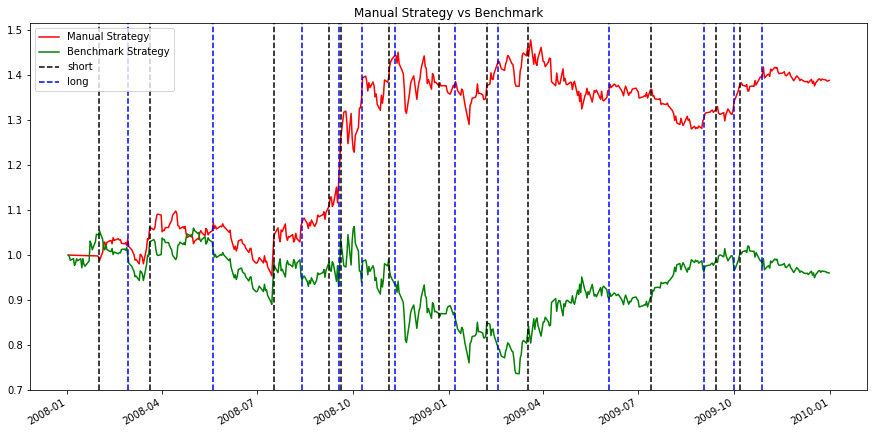

In [8]:
if __name__ == '__main__':
    test_code()
   